In [19]:
import pandas as pd 
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
import random
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series
from sklearn.metrics import mean_absolute_error, mean_squared_error

import numpy as np

random.seed(30)

df = pd.read_csv("data/us_change.csv", index_col=0)
df

,Quarter,Consumption,Income,Production,Savings,Unemployment
1,1970 Q1,0.618566,1.044801,-2.452486,5.299014,0.9
2,1970 Q2,0.451984,1.225647,-0.551459,7.789894,0.5
3,1970 Q3,0.872872,1.585154,-0.358652,7.403984,0.5
4,1970 Q4,-0.271848,-0.239545,-2.185691,1.169898,0.7
5,1971 Q1,1.901345,1.975925,1.909764,3.535667,-0.1
...,...,...,...,...,...,...
194,2018 Q2,0.983112,0.661825,1.117424,-2.723974,0.0
195,2018 Q3,0.853181,0.806271,1.256722,-0.085686,-0.3
196,2018 Q4,0.356512,0.695142,0.948148,5.031337,0.2
197,2019 Q1,0.282885,1.100753,-0.488206,9.760287,-0.1


In [ ]:
def convert_to_period(quarter):
    """
    Function to convert a string to a pandas period object. 
    Checks if the input is a string in the form '2019 Q1' or already a Period.
    """
    if isinstance(quarter, pd.Period):
        return quarter
    year, quarter_str = quarter.split()
    year = int(year)
    quarter = int(quarter_str[-1])
    return pd.Period(year=year, quarter=quarter, freq='Q')

df['Quarter'] = df['Quarter'].apply(convert_to_period)

In [7]:
flt = (df["Quarter"] >= "1970Q1") & (df["Quarter"] <= "2019Q2")
Consumption = df[["Quarter", "Consumption"]][flt]
Consumption.set_index("Quarter", inplace=True)

Consumption.head()

,Consumption
Quarter,
1970Q1,0.618566
1970Q2,0.451984
1970Q3,0.872872
1970Q4,-0.271848
1971Q1,1.901345


In [17]:
def mean_absolute_scaled_error(y_true, y_pred, y_train):
    """
    Função para calcular o MASE (Mean Absolute Scaled Error).
    """
    naive_forecast = np.roll(y_train, 1)[1:]  # Série atrasada para o erro naive
    mae_naive = mean_absolute_error(y_train[1:], naive_forecast)
    mae_model = mean_absolute_error(y_true, y_pred)
    return mae_model / mae_naive

In [ ]:
def fit_and_plot(dataset, strategy, sp=1):
    """
    Function to fit a forecasting strategy and plot the results,
    including the calculation of MAE, RMSE, and MASE.
    """

    train, test = dataset[:-7], dataset[-7:]
    

    forecaster = NaiveForecaster(strategy=strategy, sp=sp)
    forecaster.fit(train)
    y_pred = forecaster.predict(list(range(1, 8)))
    pred_intervals_95 = forecaster.predict_interval(coverage=0.95)
    pred_intervals_80 = forecaster.predict_interval(coverage=0.80)
    
    mae = mean_absolute_error(test, y_pred)
    rmse = np.sqrt(mean_squared_error(test, y_pred))
    mase = mean_absolute_scaled_error(test, y_pred, train)
    
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print(f"MASE: {mase}")
    

    plot_series(dataset, 
                y_pred,
                labels=["y_train", "y_pred"], 
                pred_interval=pred_intervals_95)
    
    plot_series(dataset,
                y_pred,
                labels=["y_train", "y_pred"],
                pred_interval=pred_intervals_80)
    
    plt.show()


### Mean Method

MAE: 0.3262584344237739
RMSE: 0.34364480801575337
MASE: 0.5889024673817349


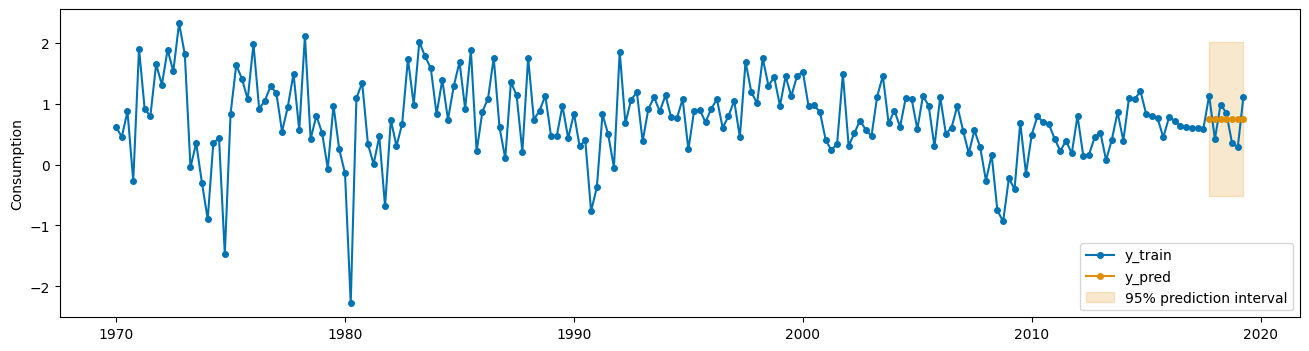

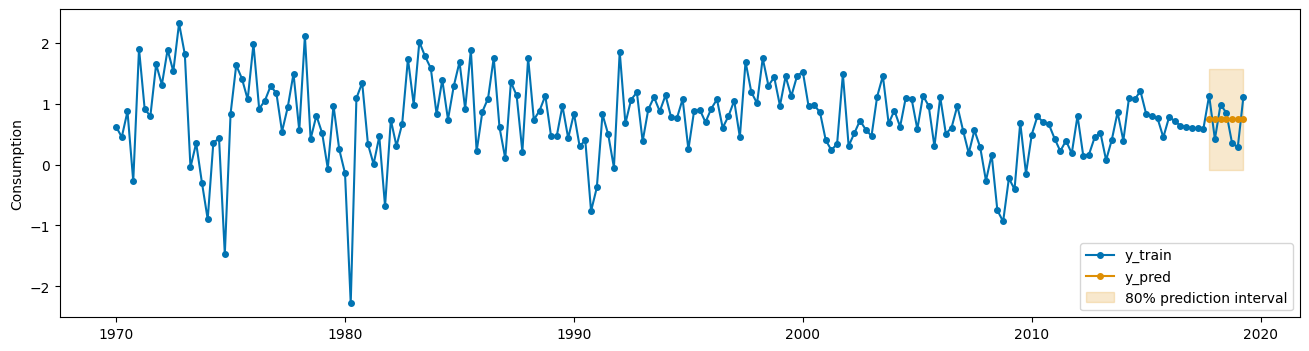

In [21]:
fit_and_plot(Consumption, strategy="mean")


### Naive (or random walk) method

MAE: 0.348836742024134
RMSE: 0.3746373713235382
MASE: 0.6296567273555483


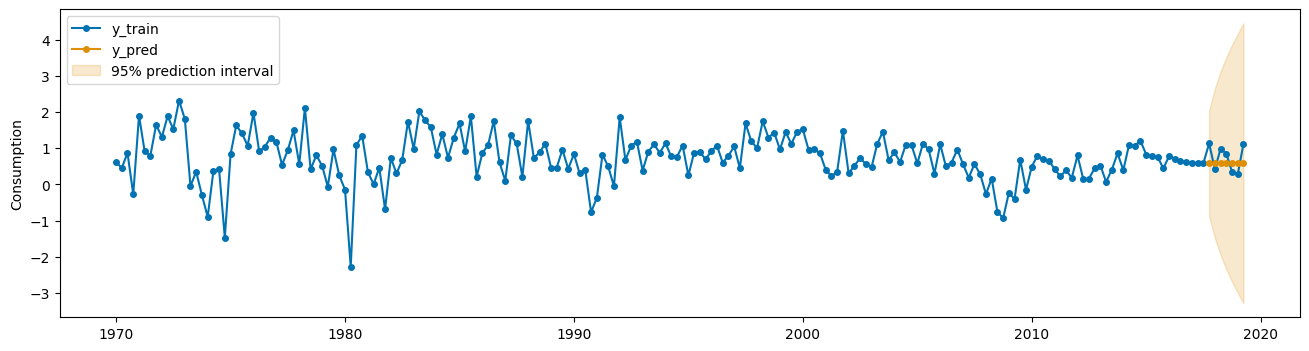

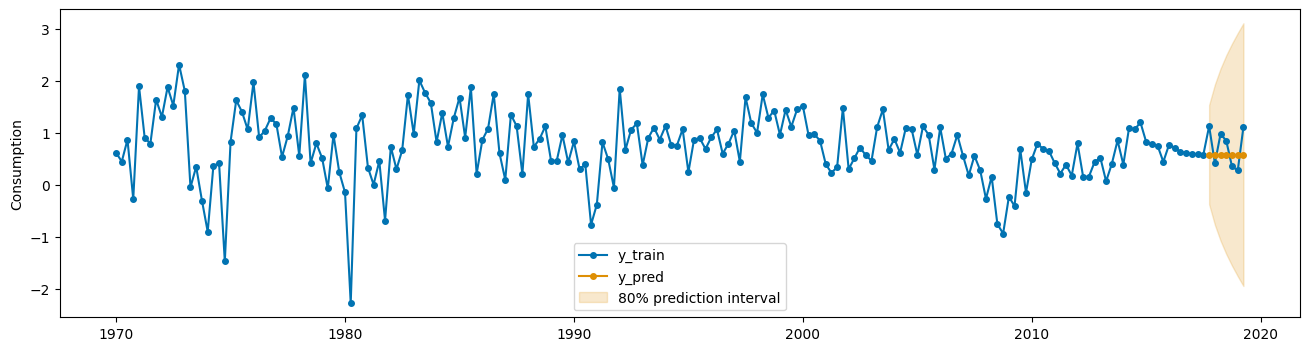

In [22]:
fit_and_plot(Consumption, strategy="last")

### Seasonal Naive method

MAE: 0.25003500467045153
RMSE: 0.30011170192900877
MASE: 0.4513177764807632


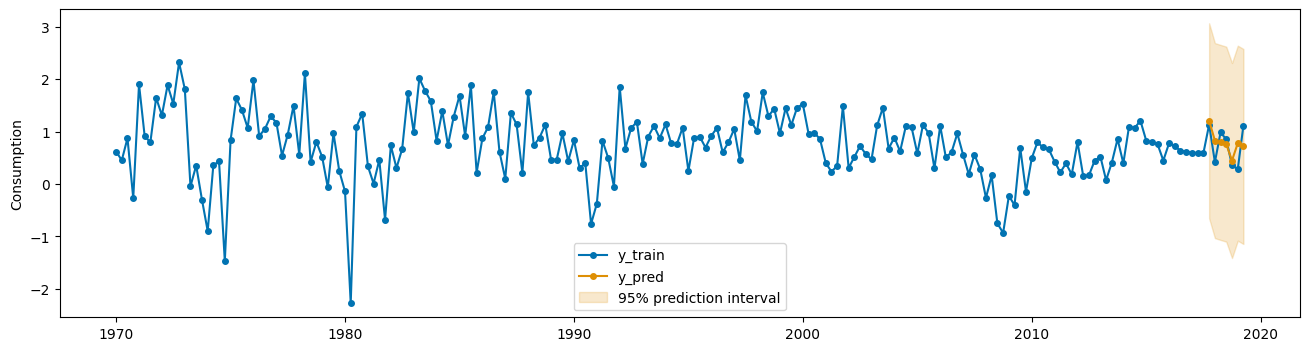

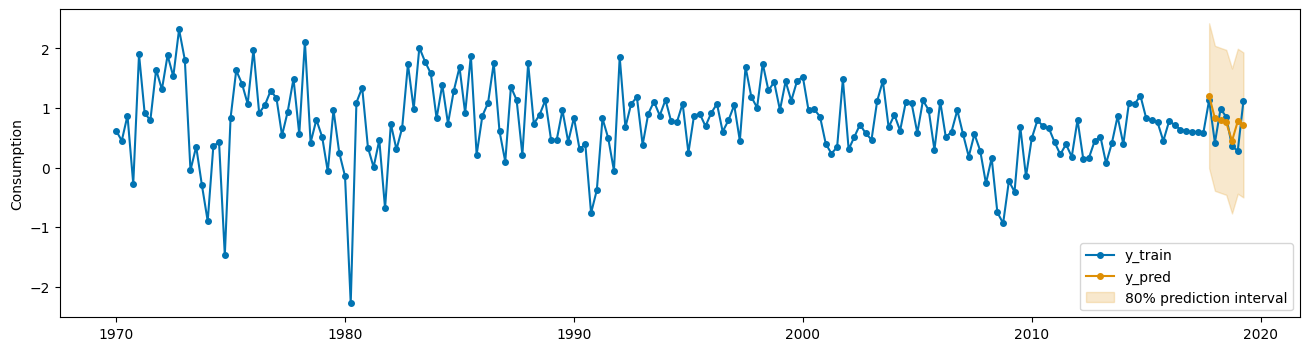

In [30]:
fit_and_plot(Consumption, strategy="last", sp=12)


### Drift method

MAE: 0.3488876119474394
RMSE: 0.37485750992057465
MASE: 0.6297485485015762


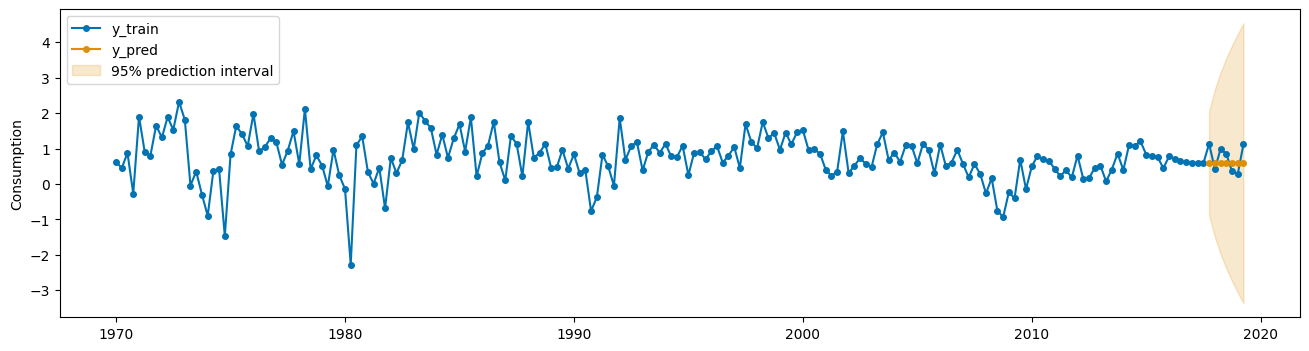

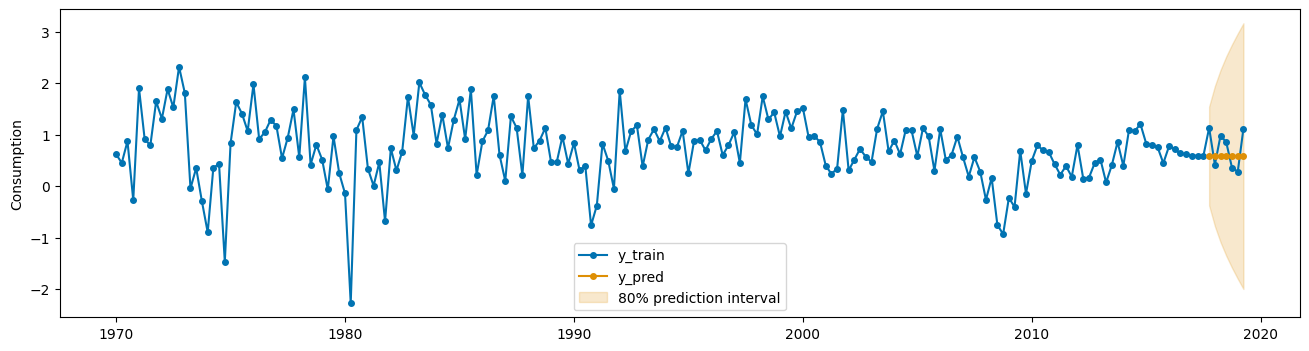

In [31]:
fit_and_plot(Consumption, strategy="drift")
